# Neural and Universal Ordinary Differential Equations: Part 02
Following along from notes by [Chris Rackauckas](https://mitmath.github.io/18S096SciML/lecture3/diffeq_ml).

In the previous notebook is documented how we can use a neural network to solve a parameter problem relating to an ODE -- we essentially trained a neural network on an ODE model, and attempted to find a best fit for the model parameters.


In [1]:
using OrdinaryDiffEq, Flux, DiffEqFlux, Plots

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1251510723916641380\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13695634961432416730\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1251510723916641380\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## Defining and Training Neural ODEs

Defining a neural ODE is the same as defining a parameterized differential equation, except here the parameterized ODE is a NN. 

Consider the following example; we wish to match the following data:

In [2]:
u0 = Float32[2.; 0.]
datasize = 30
tspan = (0.0f0, 1.5f0)

function trueODE!(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end

t = range(tspan[1], tspan[2], length=datasize)
prob = ODEProblem(trueODE!, u0, tspan)
ode_data = Array(solve(prob, Tsit5(), saveat=t))

2×30 Matrix{Float32}:
 2.0  1.9465    1.74178  1.23837  0.577125  …  1.40688   1.37023   1.29215
 0.0  0.798831  1.46473  1.80877  1.86465      0.451367  0.728692  0.972095

Let us quickly visualise this data:

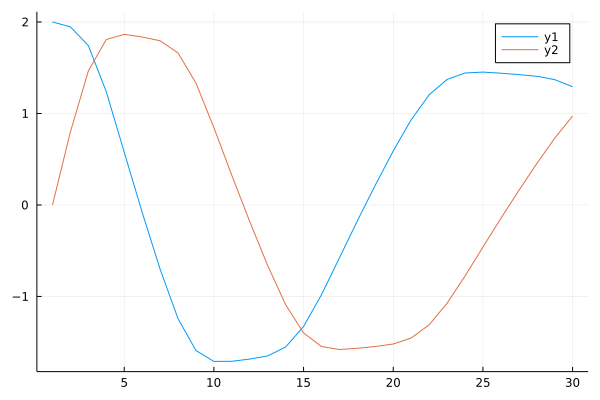

In [3]:
plot(ode_data')

We will use a so-called *knowledge-infused approach*; that is to say, we assume that we knew the ODE had cubic behaviour. We can attempt to encode that physical information into a dense NN as:

In [4]:
# build a NN
dudt = Chain(
    x -> x.^3,
    Dense(2, 50, tanh),
    Dense(50, 2)
)

Chain(
  var"#1#2"(),
  Dense(2, 50, tanh),                   # 150 parameters
  Dense(50, 2),                         # 102 parameters
)                   # Total: 4 arrays, 252 parameters, 1.234 KiB.

To train this network we will make use of `Flux.destructure` and `Flux.restructure`, allowing us to take the parameters out of a NN into a vector, and similarly rebuild a NN from a parameter vector. 

Using these, we define the ODE:

In [5]:
p, re = Flux.destructure(dudt)
dudt2_(u, p, t) = re(p)(u)
prob2 = ODEProblem(dudt2_, u0, tspan, p)

ODEProblem with uType Vector{Float32} and tType Float32. In-place: false
timespan: (0.0f0, 1.5f0)
u0: 2-element Vector{Float32}:
 2.0
 0.0

This is equivalent to

$$u^\prime = \text{NN}(u)$$

where the parameters are the parameters of the NN. We then use the same structure as before to train the network to reconstruct the ODE:


In [6]:
function predict_n_ode()
    Array(concrete_solve(prob2, Tsit5(), u0, p, saveat=t))
end

loss_n_ode() = sum(abs2, ode_data .- predict_n_ode())


data = Iterators.repeated((), 300)
opt = ADAM(0.1)

training_plots = []
iter = 0

callback = function()
    global iter += 1
    if iter % 50 == 0
        @show loss_n_ode()

        cur_pred = predict_n_ode()
        pl = Plots.scatter(t, ode_data[1,:], label="data")
        Plots.scatter!(pl, t, cur_pred[1,:], label="prediction")
        push!(training_plots, plot(pl))
    end
end

ps = Flux.params(p)
Flux.train!(loss_n_ode, ps, data, opt, cb=callback)
"Done"

loss_n_ode() = 10.00524f0
loss_n_ode() = 2.0725229f0
loss_n_ode() = 0.83961827f0
loss_n_ode() = 0.5685626f0
loss_n_ode() = 0.38171425f0
loss_n_ode() = 0.19634308f0


"Done"

We can then view our plots:

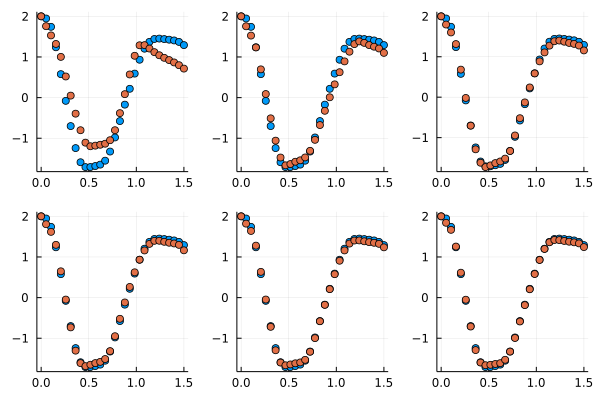

In [7]:
# using interactive widget
plot(training_plots...; legend=false)

And true enough, we were able to fit the parameters of the neural network (can we extract true A from this?).

## Augmented Neural ODE
Not every function can be represented by an ODE; specifically, some

$$u(t) : \mathbb{R} \rightarrow \mathbb{R}^n$$

would be unable to be multivariate unless cyclic.

This is because the *flow* of the ODE is unique at every $t$; for the above mapping to have at least *two directions of flow* for a given point $u_i$, there would have to be at least *two solutions* in phase space to

$$u^\prime = f(u, p, t),$$

using the convention $u(0) = u_i$, which cannot happen with a monotonic map.

We can rectify this by introducing additional degrees of freedom, to ensure that the ODE does not overlap. This is the so-called *augmented neural ODE*. 

This can be built using the following prescription:
- add a fake state to the ODE which is 0 everywhere
- allow this extra dimension to *bump* around to let the function become a [universal approximator](https://en.wikipedia.org/wiki/Universal_approximation_theorem)

In Julia, this is:
```julia
dudt = Chain(...)
p, re = Flux.destructure(dudt)

dudt_(u, p, t) = re(p)(u)
prob = ODEProblem(dudt_, [u0, f0], tspan, p)

augmented_data = vcat(
    ode_data,
    zeros(
        1,
        size(ode_data, 2)
    )
)
```